In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts

# Example cache directory path, it determines where downloaded data will be stored
output_dir = './ecephys_cache_dir/'

manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

pd.set_option('display.max_columns', None)

In [2]:
session_id = 721123822 # 797828357
session = cache.get_session_data(session_id)

## Get units in area of interest

In [3]:
VI_structure_acronyms = [x for x in cache.get_structure_acronyms() if x is not np.nan and 'VI' in x]

In [4]:
# units in a session after quality filter
VI_units = session.units.loc[[i for i, x in session.units.iterrows() if x['ecephys_structure_acronym'] in VI_structure_acronyms]]
len(VI_units)

214

In [5]:
# # Spike time data is missing for units filtered out in a session
# units = cache.get_units(amplitude_cutoff_maximum = np.inf,
#                         presence_ratio_minimum = -np.inf,
#                         isi_violations_maximum = np.inf)
# units = units[units['ecephys_session_id'] == session_id]

# VI_units_all = units.loc[[i for i, x in units.iterrows() if x['ecephys_structure_acronym'] in VI_structure_acronyms]]
# len(VI_units_all)

### Find center channel

In [6]:
ecephys_structure_acronyms = 'VISp'
sel_units = VI_units[VI_units['ecephys_structure_acronym'] == ecephys_structure_acronyms]
# sel_units = VI_units

In [7]:
# units center
ccf_coords = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
units_coord = sel_units[ccf_coords].values
units_coord_mean = units_coord.mean(axis=0)
center_unit_id = sel_units.index[np.argmin(np.sum((units_coord - units_coord_mean) ** 2, axis=1))]

channel_index = sel_units.loc[center_unit_id, 'probe_channel_number']
probe_id = sel_units.loc[center_unit_id, 'probe_id']

channel = session.channels[(session.channels.probe_channel_number == channel_index) & 
                           (session.channels.probe_id == probe_id)]
channel

,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,,
850245985,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,234,59,760213145,2360,VISp,385.0,VISp,8650.0,1130.0,8035.0


In [8]:
# channels center
channels_coord = session.channels[ccf_coords].values
center_channel_id = session.channels.index[np.argmin(np.sum((channels_coord - units_coord_mean) ** 2, axis=1))]
session.channels.loc[[center_channel_id]]

,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,,
850245983,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,233,11,760213145,2340,VISp,385.0,VISp,8646.0,1141.0,8035.0


## Analyze spikes

### Get drifting gratings stimulus information

In [9]:
def align_gratings(stimulus_presentations, stimulus_name='drifting_gratings'):
    presentations = stimulus_presentations[stimulus_presentations.stimulus_name == stimulus_name]
    null_rows = presentations[presentations['orientation'].values == 'null']
    if len(null_rows):
        null_condition = null_rows.iloc[0]['stimulus_condition_id']
        presentations = presentations[presentations['stimulus_condition_id'] != null_condition]

    presentations_times = presentations['start_time'].values
    presentations_ids = presentations.index.values
    trial_duration = presentations['duration'].max()
    return presentations, presentations_ids, presentations_times, trial_duration

def presentation_conditions(presentations, condtion_types):
    conditions = {c: np.unique(presentations[c]).astype(float) for c in condtion_types}
    cond_id_map = dict(zip(map(tuple, presentations[conditions.keys()].values),
                           presentations['stimulus_condition_id']))
    condition_id = [cond_id_map[x, y] for x, y in zip(*map(np.ravel, np.meshgrid(*conditions.values(), indexing='ij')))]
    condition_id = xr.DataArray(np.reshape(condition_id, tuple(map(len, conditions.values()))), coords=conditions, name='condition_id')
    cond_presentation_id = {c: presentations.index[presentations['stimulus_condition_id'] == c] for c in condition_id.values.ravel()}
    return condition_id, cond_presentation_id

In [10]:
stimulus_name = 'drifting_gratings'
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=stimulus_name)

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

In [11]:
bin_width = 0.03 # sec
window = (-0.5, grating_duration)
bin_edges = np.concatenate((np.arange(-bin_width / 2, window[0] - bin_width / 2, -bin_width)[::-1],
                            np.arange(bin_width / 2, window[1] + bin_width / 2, bin_width)))

# get spike count histogram for each unit
units_fr = session.presentationwise_spike_counts(stimulus_presentation_ids=grating_ids, unit_ids=sel_units.index, bin_edges=bin_edges)
# average over trials
units_fr = [units_fr.sel(stimulus_presentation_id=i).mean(dim='stimulus_presentation_id') for i in cond_presentation_id.values()]
# collect different conditions
units_fr = xr.concat(units_fr, dim=pd.Index(cond_presentation_id, name='condition_id'))
# convert to firing rate in Hz
units_fr = (units_fr / bin_width).to_dataset(name='spike_rate').assign_attrs(bin_width=bin_width)
# units mean firing rate
units_fr = units_fr.assign(units_mean_fr=units_fr.spike_rate.mean(dim=['condition_id', 'time_relative_to_stimulus_onset']))

### Preprocess units firing rate

In [12]:
def preprocess_firing_rate(units_fr, sigma, soft_normalize_cut, units_mean_fr=None):
    if units_mean_fr is None:
        units_mean_fr = units_fr.units_mean_fr
    axis = units_fr.spike_rate.dims.index('time_relative_to_stimulus_onset')
    smoothed = sp.ndimage.gaussian_filter1d(units_fr.spike_rate - units_mean_fr,
                                            sigma / units_fr.bin_width, axis=axis, mode='constant')
    smoothed = units_fr.spike_rate.copy(data=smoothed) + units_mean_fr
    units_fr = units_fr.assign(smoothed=smoothed)
    normalized = smoothed / (units_mean_fr + soft_normalize_cut)
    units_fr = units_fr.assign(normalized=normalized)
    return units_fr

sigma = 0.02 # sec
quantile = 0.2
soft_normalize_cut = np.quantile(units_fr.units_mean_fr, quantile)
units_fr = preprocess_firing_rate(units_fr, sigma, soft_normalize_cut)

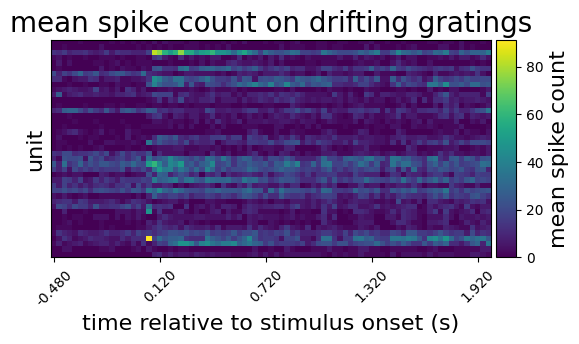

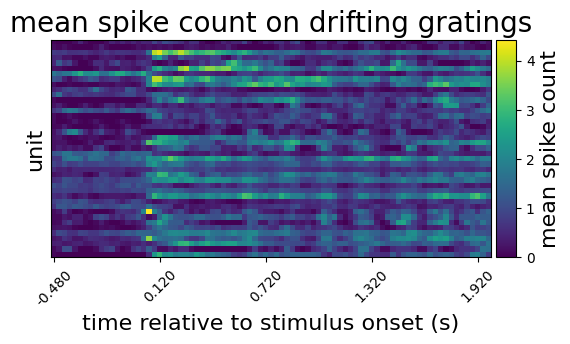

In [13]:
# Example condition activity
cond_id = condition_id[0, 0]
units_fr0 = units_fr.spike_rate.sel(condition_id=cond_id)
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0.time_relative_to_stimulus_onset,
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)

units_fr0 = units_fr.normalized.sel(condition_id=cond_id)
plot_spike_counts(
    units_fr0, 
    time_coords=units_fr0.time_relative_to_stimulus_onset,
    cbar_label='mean spike count', 
    title='mean spike count on drifting gratings',
    xtick_step=20,
)
plt.gcf().set_figwidth(6)
plt.gcf().set_figheight(3)
plt.show()

### PCA analysis

In [14]:
from sklearn.decomposition import PCA

units_vec = units_fr.normalized.stack(sample=['condition_id', 'time_relative_to_stimulus_onset']).T

n_units = units_vec.unit_id.size
n_components = n_units
pca = PCA(n_components=n_components)
pca.fit(units_vec)
pop_vec = pca.transform(units_vec)
pop_vec = units_vec.copy(data=pop_vec).rename(unit_id='PC').unstack('sample')
pop_vec.coords['PC'] = range(n_components)
print('Explained variance % of top 10 components: \n' + 
      ', '.join('%.2f' % (100 * x) for x in pca.explained_variance_ratio_[:10]))

Explained variance % of top 10 components: 
21.61, 15.33, 14.51, 7.64, 5.40, 4.67, 2.81, 2.48, 2.06, 1.77


In [15]:
pop_vec_cond = pop_vec.sel(condition_id=condition_id)
n_orient = pop_vec_cond.orientation.size
n_tfreq = pop_vec_cond.temporal_frequency.size

cmap = plt.cm.get_cmap('hsv')(np.arange(n_orient) / n_orient)[:, :3]
def lighten(val, clr):
    clr1 = 1 - (1 - clr) * 0.5
    clr2 = clr * 0.6
    return (1 - val) * clr1 + val * clr2

Time interval: (-30.0, 330.0) ms


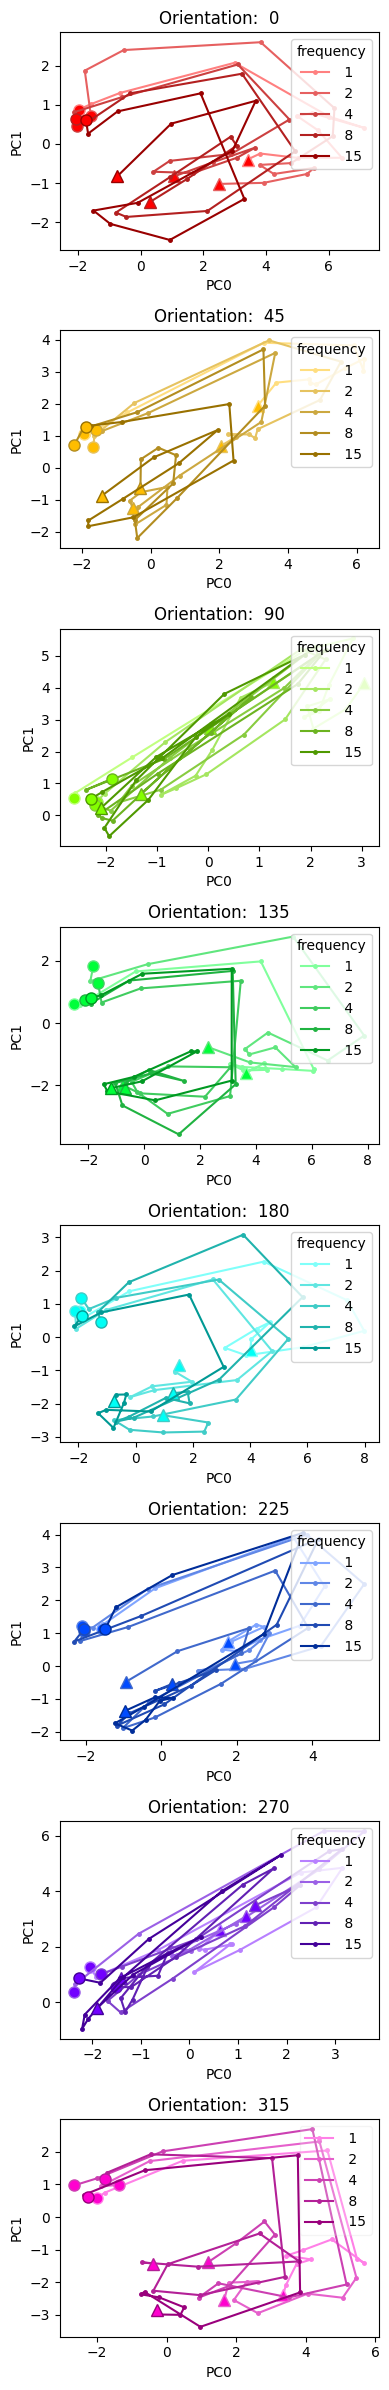

In [16]:
PC_axis = [0, 1]
ts = np.linspace(0, 1, n_tfreq)
_, axs = plt.subplots(n_orient, 1, figsize=(4, 3 * n_orient))
axs = axs.ravel()
for i, orient in enumerate(pop_vec_cond.orientation):
    ax = axs[i]
    pop_vec_orient = pop_vec_cond.sel(PC=PC_axis, orientation=orient, time_relative_to_stimulus_onset=slice(-0.05, 0.33))
    for j, tfreq in enumerate(pop_vec_cond.temporal_frequency):
        clr = lighten(ts[j], cmap[i])
        pop_vec_tfreq = pop_vec_orient.sel(temporal_frequency=tfreq)
        ax.plot(*pop_vec_tfreq, color=clr, marker='.', markersize=5, label=f'{tfreq: .0f}')
        ax.plot(*pop_vec_tfreq[:, 0], linestyle='none', marker='o',
                markersize=8, markeredgecolor=clr, markerfacecolor=cmap[i])
        ax.plot(*pop_vec_tfreq[:, -1], linestyle='none', marker='^',
                markersize=8, markeredgecolor=clr, markerfacecolor=cmap[i])
    ax.set_xlabel(f'PC{PC_axis[0]:d}')
    ax.set_ylabel(f'PC{PC_axis[1]:d}')
    ax.legend(loc='upper right', title='frequency')
    ax.set_title(f'Orientation: {orient: .0f}')
plt.legend(loc='upper right', framealpha=0.2)
plt.tight_layout()

print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * pop_vec_orient.time_relative_to_stimulus_onset[[0, -1]]))
plt.show()

Time interval: (-30.0, 330.0) ms


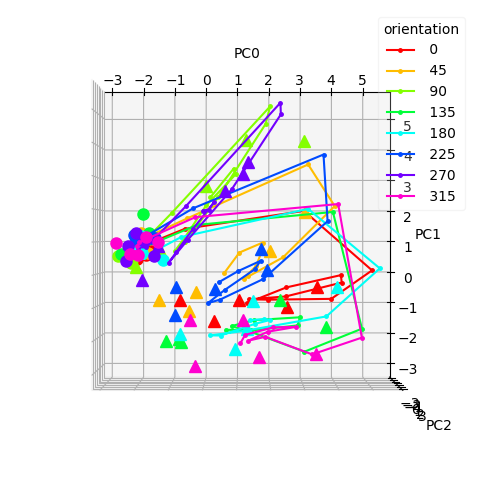

In [17]:
# %matplotlib notebook

PC_axis = [0, 1, 2]
ts = np.linspace(0, 1, n_tfreq)
ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
for i, orient in enumerate(pop_vec_cond.orientation):
    pop_vec_orient = pop_vec_cond.sel(PC=PC_axis, orientation=orient, time_relative_to_stimulus_onset=slice(-0.05, 0.33))
    pop_vec_tfreq = pop_vec_orient.mean(dim='temporal_frequency')
    clr = cmap[i]
    ax.plot(*pop_vec_tfreq, color=clr, marker='.', markersize=5, label=f'{orient: .0f}')
    ax.plot(*pop_vec_orient[:, :, 0], linestyle='none', marker='o',
            markersize=8, markeredgecolor=clr, markerfacecolor=clr)
    ax.plot(*pop_vec_orient[:, :, -1], linestyle='none', marker='^',
            markersize=8, markeredgecolor=clr, markerfacecolor=clr)
ax.set_xlabel(f'PC{PC_axis[0]:d}')
ax.set_ylabel(f'PC{PC_axis[1]:d}')
ax.set_zlabel(f'PC{PC_axis[2]:d}')
ax.legend(loc='upper right', title='orientation', framealpha=0.2)
ax.view_init(90, -90) # xy
# ax.view_init(0, -90) # xz
# ax.view_init(0, 0) # yz

print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * pop_vec_orient.time_relative_to_stimulus_onset[[0, -1]]))
plt.show()

In [18]:
n_top_pc = 3
PC_axis = np.arange(n_top_pc)
units_pc = np.sum(pca.components_[PC_axis] ** 2, axis=0) ** 0.5

pca_df = pd.DataFrame(
    {
        'mean_firing_rate': units_fr.units_mean_fr,
        'projection_on_top_PCs': units_pc,
        **{f'PC_{p:d}_component': pca.components_[p] for p in PC_axis}
    },
    index = pd.Index(units_fr.unit_id, name='unit_id')
)

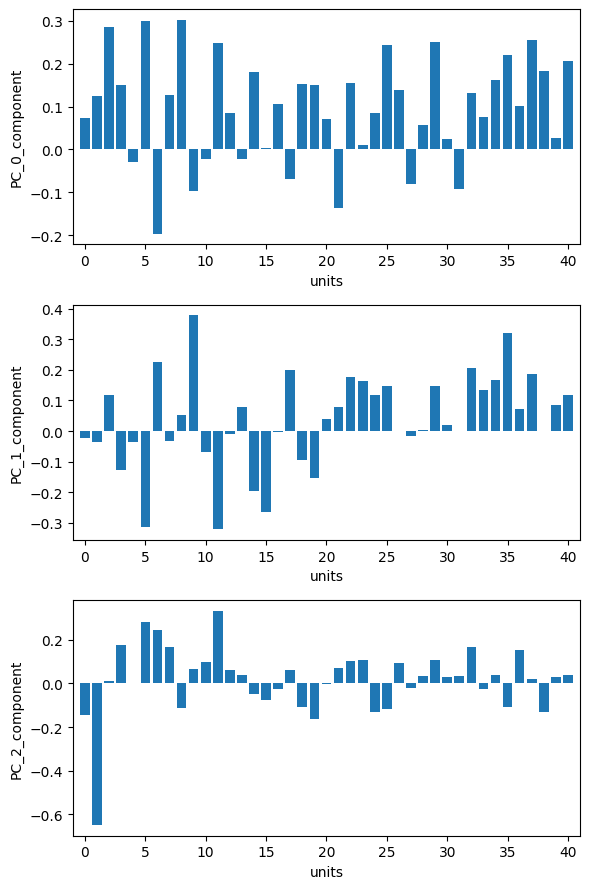

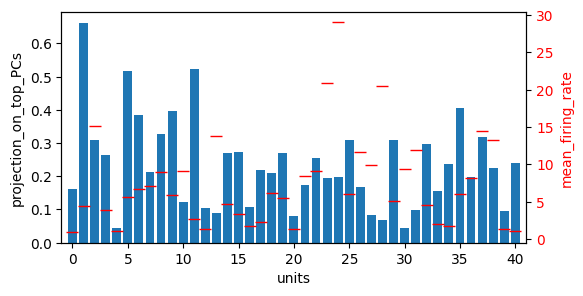

In [19]:
_, axs = plt.subplots(n_top_pc, 1, figsize=(6, 3 * n_top_pc))
for i in range(n_top_pc):
    ax = axs[i]
    label = f'PC_{PC_axis[i]:d}_component'
    ax.bar(range(n_units), pca_df[label])
    ax.set_xlim(-1, n_units)
    ax.set_xlabel('units')
    ax.set_ylabel(label)
plt.tight_layout()

_, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(range(n_units), pca_df['projection_on_top_PCs'])
ax.set_xlim(-1, n_units)
ax.set_xlabel('units')
ax.set_ylabel('projection_on_top_PCs')
ax2 = ax.twinx()
ax2.plot(range(n_units), pca_df['mean_firing_rate'], color='r', linestyle='none', marker='_', markersize=8)
ax2.set_ylabel('mean_firing_rate', color='r')
ax2.tick_params(axis ='y', labelcolor='r')

plt.show()

In [20]:
# # Save data
# filepath = os.path.join(output_dir, 'session_%d' % session_id,
#                         'lfp_probe%d_%s_%s_units_pca.csv' % (probe_id, ecephys_structure_acronyms, stimulus_name))
# pca_df.to_csv(filepath)